In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, precision_recall_curve, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from scipy.stats import pointbiserialr
from sklearn import tree

## Load Datasets# 

In [2]:
train_dt = pd.read_csv('train.csv')
test_dt = pd.read_csv('test.csv')

## Helper Functions

In [3]:
def cramers_corrected_stat(train_dt,chi_test_stats,crosstab):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    n = len(train_dt)
    phi = chi_test_stats/n
    r,k = crosstab.shape    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    #print(n,phi,r,k)
    return np.sqrt(phi / min( (kcorr-1), (rcorr-1)))

## Exploratory Data Analysis

### What is the shape of the datasets?

In [4]:
print('Shape of train dataset:',train_dt.shape)
print('Shape of test dataset:',test_dt.shape)

Shape of train dataset: (891, 12)
Shape of test dataset: (418, 11)


### Details of the fields (Name, Datatypes)

In [5]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Observations:
1. Categorical Features : Embarked, Sex, PClass, Parch, SibSp
2. Numerical Features: Fare, Age
3. Alphanumeric/string: Name, Cabin, Ticket

### Features having missing values

In [6]:
train_dt.columns[train_dt.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

###  Class Distribution 

In [7]:
round(train_dt.groupby(by=['Survived'])['PassengerId'].count()/len(train_dt)*100)

Survived
0    62.0
1    38.0
Name: PassengerId, dtype: float64

### Some Assumptions:
1. Females had more survival chances. 
2. Survival rate changes with respect to the passenger class. 

### Sex: 

1. What is the distribution? 

In [8]:
round(train_dt.groupby(by=['Sex'])['PassengerId'].count()/len(train_dt)*100)

Sex
female    35.0
male      65.0
Name: PassengerId, dtype: float64

2. What is survival percentage of each gender ? 

In [9]:
train_dt[train_dt['Survived']==1].groupby(by=['Sex'])['PassengerId'].count()/len(train_dt)*100

Sex
female    26.150393
male      12.233446
Name: PassengerId, dtype: float64

3. Barplot of Survival and Sex

In [10]:
grp_dt = train_dt[['Sex','Survived','PassengerId']].groupby(by=['Sex','Survived']).count().reset_index()
grp_dt

Sex  Survived  PassengerId
0  female         0           81
1  female         1          233
2    male         0          468
3    male         1          109

Text(0, 0.5, 'Frequency')

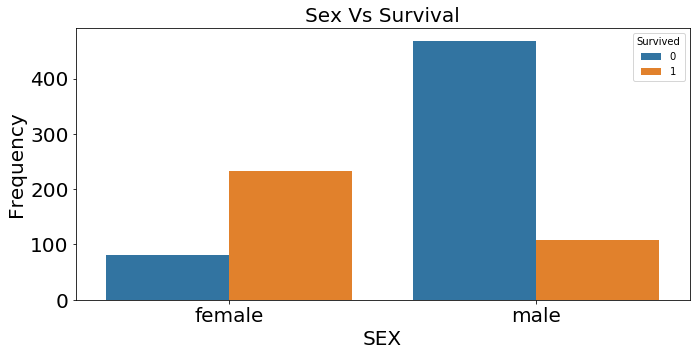

In [11]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Sex',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Sex Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('SEX', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p>Interestingly, only <b>12%</b> male survived out of <b>65%</b> which means <b>53%</b> male couldn't survived in this tragic incident whereas, there is only <b>9%</b> females who died in this incident but the majority of the females survived that is <b>26%</b>. Hence we can say <b>Sex</b> can be a good predictor  </p>
</div>

4. Coorelation of Sex With Survival. 

In [12]:
sexCrossTab = pd.crosstab(train_dt['Sex'],train_dt['Survived'])

In [13]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(sexCrossTab)

In [14]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 260.71702016732104 P-Value 1.1973570627755645e-58


In [15]:
cramers_corrected_stat(train_dt,testStatistic,sexCrossTab)

0.5412400963770316

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Sex is one of the decisive feature in this problem and the coorelation is reasonable (not too weak not too strong) </p>
</div>

### Passenger Class: 

1. What is the distribution?

In [16]:
train_dt.groupby(by=['Pclass'])['PassengerId'].count()/len(train_dt)*100

Pclass
1    24.242424
2    20.650954
3    55.106622
Name: PassengerId, dtype: float64

2. What is the survival percentage in each class of passenger?

In [17]:
train_dt[train_dt['Survived']==1].groupby(by=['Pclass'])['PassengerId'].count()/len(train_dt)*100

Pclass
1    15.263749
2     9.764310
3    13.355780
Name: PassengerId, dtype: float64

3. Barplot of Survival and Passenger Class

In [18]:
grp_dt = train_dt[['Pclass','Survived','PassengerId']].groupby(by=['Pclass','Survived']).count().reset_index()
grp_dt

Pclass  Survived  PassengerId
0       1         0           80
1       1         1          136
2       2         0           97
3       2         1           87
4       3         0          372
5       3         1          119

Text(0, 0.5, 'Frequency')

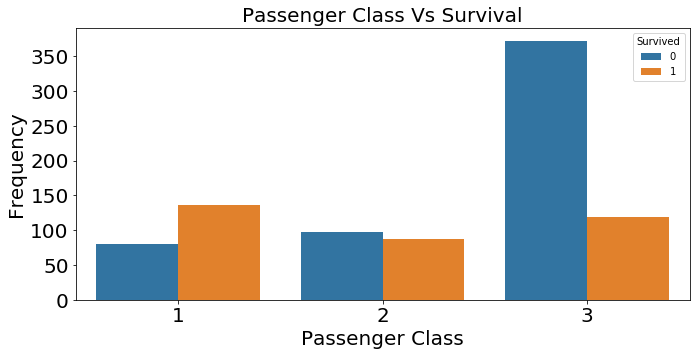

In [19]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Pclass',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Passenger Class Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Passenger Class', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p> It seems like Passenger class has significant impact on survival. The percentage difference between those who survived and those couldn't is huge in 3rd class of the passengers. Interestingly only in 1st class of passenger the number of survival are more than number of died  </p>
</div>

4. Coorelation of Passenger Class With Survival. 

In [20]:
PclassCrossTab = pd.crosstab(train_dt['Pclass'],train_dt['Survived'])

In [21]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(PclassCrossTab)

In [22]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 102.88898875696056 P-Value 4.549251711298793e-23


In [23]:
cramers_corrected_stat(train_dt,testStatistic,PclassCrossTab)

0.3400084576791133

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Pclass can be deterministic feature but the correlation is bit weak.</p>
</div>

### Age: 

1. What is the distribution?

In [24]:
train_dt['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

2. How many missing or zero values?

In [25]:
train_dt['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [26]:
train_dt[train_dt['Age'] < 1]

PassengerId  Survived  Pclass                             Name     Sex  \
78            79         1       2    Caldwell, Master. Alden Gates    male   
305          306         1       1   Allison, Master. Hudson Trevor    male   
469          470         1       3    Baclini, Miss. Helene Barbara  female   
644          645         1       3           Baclini, Miss. Eugenie  female   
755          756         1       2        Hamalainen, Master. Viljo    male   
803          804         1       3  Thomas, Master. Assad Alexander    male   
831          832         1       2  Richards, Master. George Sibley    male   

      Age  SibSp  Parch  Ticket      Fare    Cabin Embarked  
78   0.83      0      2  248738   29.0000      NaN        S  
305  0.92      1      2  113781  151.5500  C22 C26        S  
469  0.75      2      1    2666   19.2583      NaN        C  
644  0.75      2      1    2666   19.2583      NaN        C  
755  0.67      1      1  250649   14.5000      NaN        S  
803  0.42      0      1    2625    8.5167      NaN        C  
831  0.83      1      1   29106   18.7500      NaN        S

2. What is distribution of age for those who survived and those who couldn't?

In [27]:
survived = train_dt[train_dt['Survived']==1]
died = train_dt[train_dt['Survived']==0]

In [28]:
survived = survived[survived['Age'].notnull()]
died = died[died['Age'].notnull()]

Text(0.5, 1.0, 'Age Distribution (Died)')

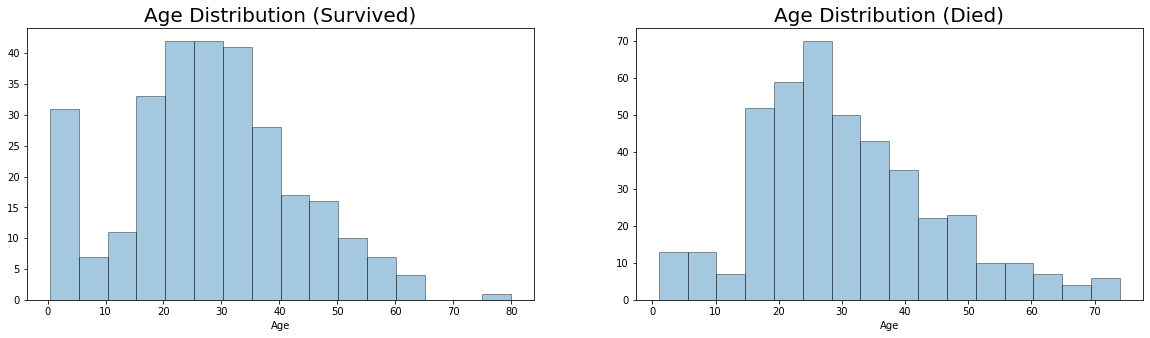

In [29]:
fig, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.distplot(survived['Age'], kde=False, hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Age Distribution (Survived)',fontsize=20)
sns.distplot(died['Age'], kde=False, hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Age Distribution (Died)',fontsize=20)

3. Bucket Analysis:

In [30]:
temp = train_dt[train_dt['Age'].notnull()]

In [31]:
temp['Age_range'] = pd.cut(temp['Age'],[1,20,40,60,100])

/home/sehan/Documents/Jupyter-notebook/my_jupyter_notebook_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
temp['Age_range'].value_counts()/len(temp)*100

(20, 40]     53.921569
(1, 20]      23.109244
(40, 60]     17.927171
(60, 100]     3.081232
Name: Age_range, dtype: float64

In [33]:
temp[temp['Survived']==1]['Age_range'].value_counts()/len(temp)*100

(20, 40]     21.428571
(1, 20]       9.803922
(40, 60]      7.002801
(60, 100]     0.700280
Name: Age_range, dtype: float64

In [34]:
temp[temp['Survived']==0]['Age_range'].value_counts()/len(temp)*100

(20, 40]     32.492997
(1, 20]      13.305322
(40, 60]     10.924370
(60, 100]     2.380952
Name: Age_range, dtype: float64

4. Age, Pclass and Survival.

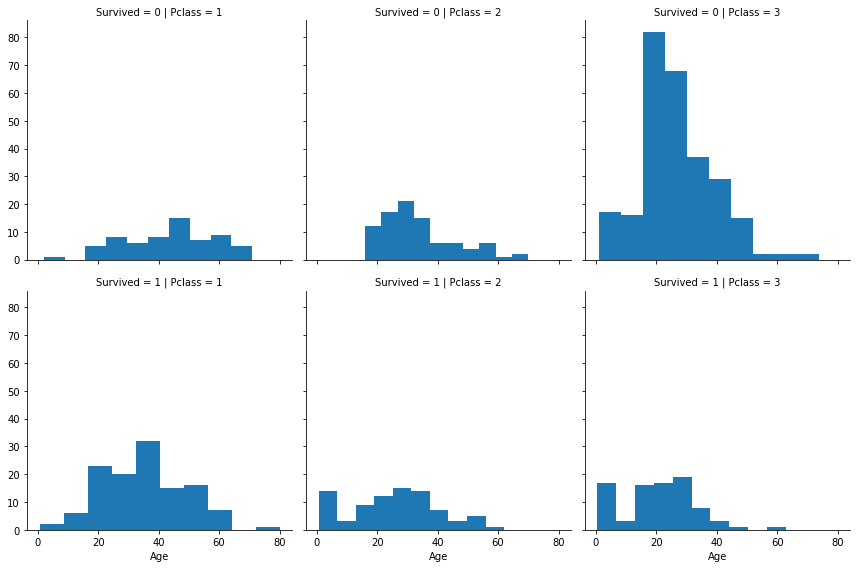

In [35]:
g = sns.FacetGrid(temp, col="Pclass",row='Survived',height=4)
g = g.map(plt.hist, "Age")

<div class='alert alert-block alert-info'>
    <p>Age distribition of each passenger class gives the following insights</p>
    <ol>
        <li>Aged people only survived in Pclass 1 </li>
        <li>Childrens survived in Pclass 2 and Pclass 3 </li>
        <li>People who have age less than 40 year had more survival chances in Pclass 3 </li>
        <li>Majority of the children died in Pclass 3 whereas, only minimal percentage of children died in Pclass 1. In Pclass 2 there is no casuality of children</li>
   </ol>
</div>

5. Sex, Age and Survival.

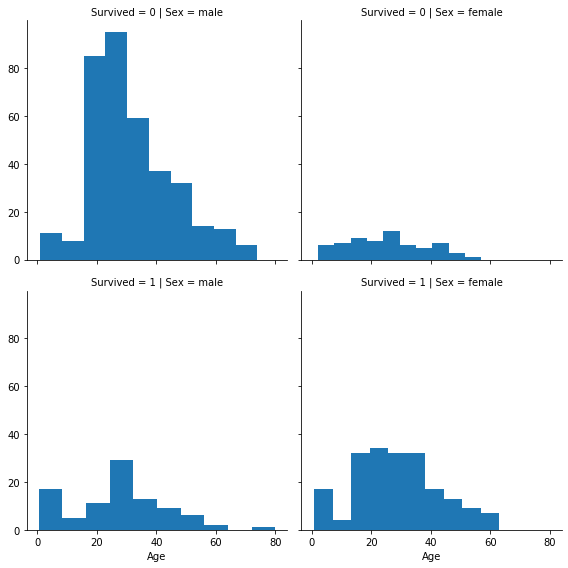

In [36]:
g = sns.FacetGrid(temp, col="Sex",row='Survived',height=4)
g = g.map(plt.hist, "Age")

6. Chisquare test for Age_range with Survival.

In [37]:
Age_rangeCrossTab = pd.crosstab(temp['Age_range'],temp['Survived'])

In [38]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(Age_rangeCrossTab)

In [39]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 3.1804575727612656 P-Value 0.3646302364909859


In [40]:
cramers_corrected_stat(train_dt,testStatistic,Age_rangeCrossTab)

0.05977919659927382

7. Logistic regression to find out correlation.

In [41]:
X = temp['Age'].values
y = temp['Survived']

In [42]:
X = X.reshape(-1,1)

In [43]:
X_train,X_test, Y_train, Y_test = train_test_split(X,y)

In [44]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [45]:
Y_pred = clf.predict(X_test)

In [46]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       114
           1       0.00      0.00      0.00        65

    accuracy                           0.64       179
   macro avg       0.32      0.50      0.39       179
weighted avg       0.41      0.64      0.50       179



/home/sehan/Documents/Jupyter-notebook/my_jupyter_notebook_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
accuracy_score(Y_test,Y_pred)

0.6368715083798883

In [48]:
confusion_matrix(Y_test,Y_pred)

array([[114,   0],
       [ 65,   0]])

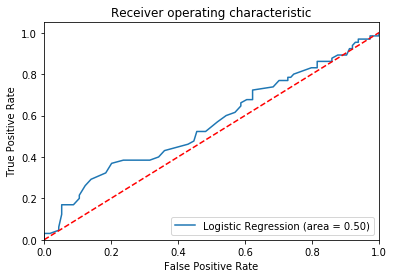

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

8. Boxplots of survived and died

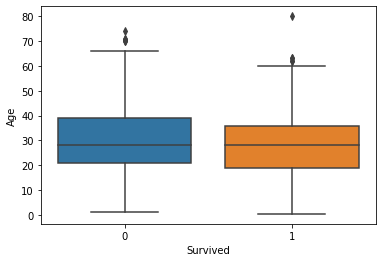

In [50]:
sns.boxplot(x='Survived',y='Age',data=temp)

In [51]:
temp.groupby(by=['Survived'])['Age'].describe()

count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0

9. Point Biserial Correlation Of age with Survival.

In [52]:
survived = temp[temp['Survived']==1]
died = temp[temp['Survived']==0]

In [53]:
# mean of each group # 
survived_mean = np.mean(survived['Age'])
died_mean = np.mean(died['Age'])

# standard deviation of Age # 
stdv = np.std(train_dt['Age'])

# number of records in each group # 
n_survived = len(survived)
n_died = len(died)

# total length of data # 
n = len(temp)

In [54]:
# Point Biserial Correlation # 
pt_bserl_corr = ((died_mean-survived_mean)/stdv)* np.sqrt((n_survived/n)*(n_died/n))

In [55]:
pt_bserl_corr

0.07722109457217761

Point Biserial from Scipy

In [56]:
pointbiserialr(temp['Age'],temp['Survived'])

PointbiserialrResult(correlation=-0.07722109457217767, pvalue=0.039124654013465966)

<div class='alert alert-block alert-info'>
    <p>After applying chi square, box plot analysis, logistic regression and Point biserial correlation it is confirm that age is not a significant predictor</p>
</div>

### Siblings and Spouse: 

1. What is the distribution? 

In [57]:
train_dt.groupby(by=['SibSp'])['PassengerId'].count()/len(train_dt)*100

SibSp
0    68.237935
1    23.456790
2     3.142536
3     1.795735
4     2.020202
5     0.561167
8     0.785634
Name: PassengerId, dtype: float64

2. What is the survival percentage with respect to number of siblings or spouse on board?

In [58]:
train_dt[train_dt['Survived']==1].groupby(by=['SibSp'])['PassengerId'].count()/len(train_dt)*100

SibSp
0    23.569024
1    12.570146
2     1.459035
3     0.448934
4     0.336700
Name: PassengerId, dtype: float64

3. Barplot of Survival and SibSp

In [59]:
grp_dt = train_dt[['SibSp','Survived','PassengerId']].groupby(by=['SibSp','Survived']).count().reset_index()
grp_dt

SibSp  Survived  PassengerId
0       0         0          398
1       0         1          210
2       1         0           97
3       1         1          112
4       2         0           15
5       2         1           13
6       3         0           12
7       3         1            4
8       4         0           15
9       4         1            3
10      5         0            5
11      8         0            7

Text(0, 0.5, 'Frequency')

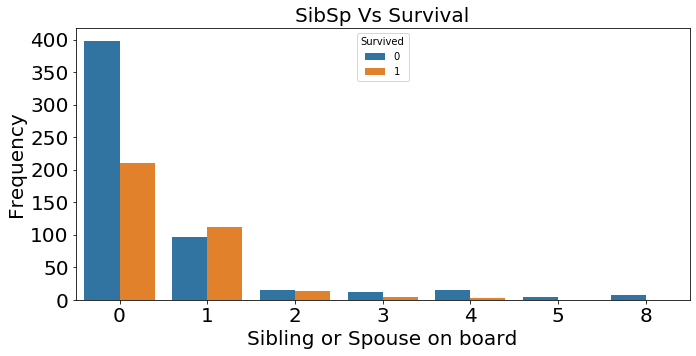

In [60]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='SibSp',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('SibSp Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Sibling or Spouse on board', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p> It seems like Siblings or Spouse on board have some impact on survival. </p>
</div>

4. Boxplot of SibSp for both groups.

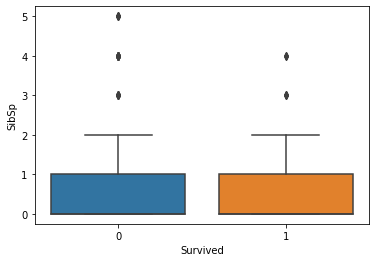

In [61]:
sns.boxplot(x='Survived',y='SibSp',data=temp)

In [62]:
train_dt.groupby(by=['Survived'])['SibSp'].mean()

Survived
0    0.553734
1    0.473684
Name: SibSp, dtype: float64

5. Coorelation of SibSp With Survival. 

In [63]:
SibSpCrossTab = pd.crosstab(train_dt['SibSp'],train_dt['Survived'])

In [64]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(SibSpCrossTab)

In [65]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 37.2717929152043 P-Value 1.5585810465902147e-06


In [66]:
cramers_corrected_stat(train_dt,testStatistic,SibSpCrossTab)

0.20464230226429342

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that SibSp can be deterministic but the correlation is very weak</p>
</div>

### Parents and Children: 

1. What is the distribution? 

In [67]:
train_dt.groupby(by=['Parch'])['PassengerId'].count()/len(train_dt)*100

Parch
0    76.094276
1    13.243547
2     8.978676
3     0.561167
4     0.448934
5     0.561167
6     0.112233
Name: PassengerId, dtype: float64

2. What is the survival percentage with respect to number of parents or children  on board?

In [68]:
train_dt[train_dt['Survived']==1].groupby(by=['Parch'])['PassengerId'].count()/len(train_dt)*100

Parch
0    26.150393
1     7.295174
2     4.489338
3     0.336700
5     0.112233
Name: PassengerId, dtype: float64

3. Barplot of Survival and Parch 

In [69]:
grp_dt = train_dt[['Parch','Survived','PassengerId']].groupby(by=['Parch','Survived']).count().reset_index()
grp_dt

Parch  Survived  PassengerId
0       0         0          445
1       0         1          233
2       1         0           53
3       1         1           65
4       2         0           40
5       2         1           40
6       3         0            2
7       3         1            3
8       4         0            4
9       5         0            4
10      5         1            1
11      6         0            1

Text(0, 0.5, 'Frequency')

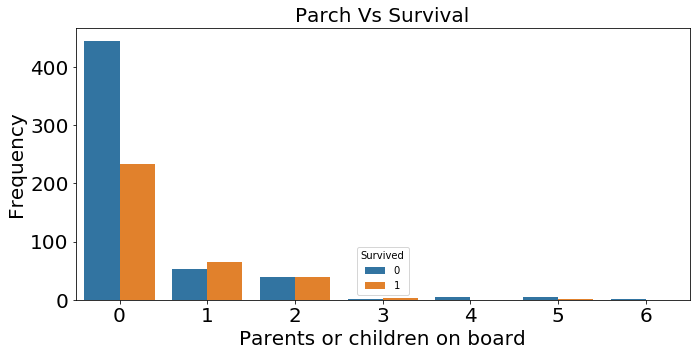

In [70]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Parch',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Parch Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Parents or children on board', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p> It seems like Parents or Children on board have some impact on survival. </p>
</div>

4. Boxplot of Parch for both groups.

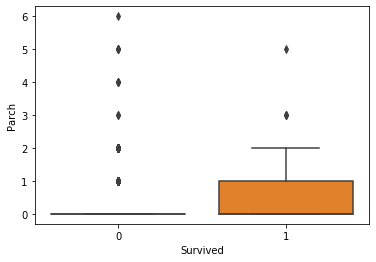

In [71]:
sns.boxplot(x='Survived',y='Parch',data=temp)

In [72]:
train_dt.groupby(by=['Survived'])['Parch'].mean()

Survived
0    0.329690
1    0.464912
Name: Parch, dtype: float64

5. Coorelation of SibSp With Survival. 

In [73]:
ParchCrossTab = pd.crosstab(train_dt['Parch'],train_dt['Survived'])

In [74]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(ParchCrossTab)

In [75]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 27.925784060236168 P-Value 9.703526421039997e-05


In [76]:
cramers_corrected_stat(train_dt,testStatistic,ParchCrossTab)

0.1771364589060439

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Parch can be deterministic but the correlation is very weak</p>
</div>

Evaluated Features: Sex, Pclass, Age, SibSp, Parch 

### Fare: 

1. What is the distribution?

Text(0.5, 1.0, 'Fare Distribution')

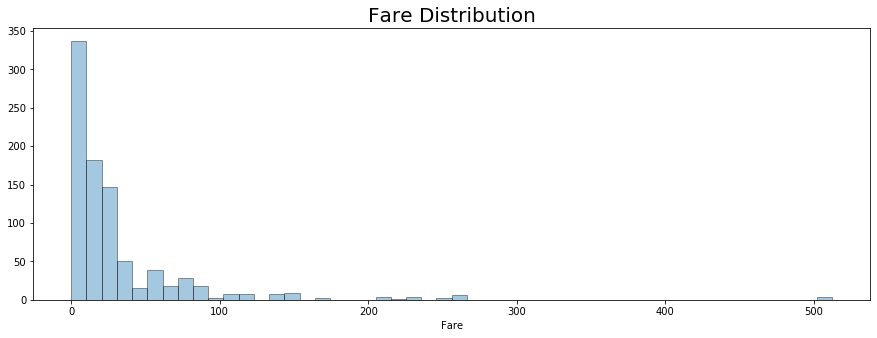

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(train_dt['Fare'], kde=False, hist_kws={'edgecolor':'Black'})
ax.set_title('Fare Distribution',fontsize=20)

2. What is the average fare? 

In [78]:
train_dt['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

3. How many instance in which fare is equal to zero?

In [79]:
train_dt[train_dt['Fare']<1]

PassengerId  Survived  Pclass                              Name   Sex  \
179          180         0       3               Leonard, Mr. Lionel  male   
263          264         0       1             Harrison, Mr. William  male   
271          272         1       3      Tornquist, Mr. William Henry  male   
277          278         0       2       Parkes, Mr. Francis "Frank"  male   
302          303         0       3   Johnson, Mr. William Cahoone Jr  male   
413          414         0       2    Cunningham, Mr. Alfred Fleming  male   
466          467         0       2             Campbell, Mr. William  male   
481          482         0       2  Frost, Mr. Anthony Wood "Archie"  male   
597          598         0       3               Johnson, Mr. Alfred  male   
633          634         0       1     Parr, Mr. William Henry Marsh  male   
674          675         0       2        Watson, Mr. Ennis Hastings  male   
732          733         0       2              Knight, Mr. Robert J  male   
806          807         0       1            Andrews, Mr. Thomas Jr  male   
815          816         0       1                  Fry, Mr. Richard  male   
822          823         0       1   Reuchlin, Jonkheer. John George  male   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
179  36.0      0      0    LINE   0.0   NaN        S  
263  40.0      0      0  112059   0.0   B94        S  
271  25.0      0      0    LINE   0.0   NaN        S  
277   NaN      0      0  239853   0.0   NaN        S  
302  19.0      0      0    LINE   0.0   NaN        S  
413   NaN      0      0  239853   0.0   NaN        S  
466   NaN      0      0  239853   0.0   NaN        S  
481   NaN      0      0  239854   0.0   NaN        S  
597  49.0      0      0    LINE   0.0   NaN        S  
633   NaN      0      0  112052   0.0   NaN        S  
674   NaN      0      0  239856   0.0   NaN        S  
732   NaN      0      0  239855   0.0   NaN        S  
806  39.0      0      0  112050   0.0   A36        S  
815   NaN      0      0  112058   0.0  B102        S  
822  38.0      0      0   19972   0.0   NaN        S

In [80]:
print(len(train_dt[train_dt['Fare']<1]))

15


4. How many instance in which fare is more than 31? 

In [81]:
high_fare = train_dt[train_dt['Fare'] > 31]
high_fare

PassengerId  Survived  Pclass  \
1              2         1       1   
3              4         1       1   
6              7         0       1   
13            14         0       3   
23            24         1       1   
..           ...       ...     ...   
856          857         1       1   
863          864         0       3   
867          868         0       1   
871          872         1       1   
879          880         1       1   

                                                  Name     Sex   Age  SibSp  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                              McCarthy, Mr. Timothy J    male  54.0      0   
13                         Andersson, Mr. Anders Johan    male  39.0      1   
23                        Sloper, Mr. William Thompson    male  28.0      0   
..                                                 ...     ...   ...    ...   
856         Wick, Mrs. George Dennick (Mary Hitchcock)  female  45.0      1   
863                  Sage, Miss. Dorothy Edith "Dolly"  female   NaN      8   
867               Roebling, Mr. Washington Augustus II    male  31.0      0   
871   Beckwith, Mrs. Richard Leonard (Sallie Monypeny)  female  47.0      1   
879      Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)  female  56.0      0   

     Parch    Ticket      Fare Cabin Embarked  
1        0  PC 17599   71.2833   C85        C  
3        0    113803   53.1000  C123        S  
6        0     17463   51.8625   E46        S  
13       5    347082   31.2750   NaN        S  
23       0    113788   35.5000    A6        S  
..     ...       ...       ...   ...      ...  
856      1     36928  164.8667   NaN        S  
863      2  CA. 2343   69.5500   NaN        S  
867      0  PC 17590   50.4958   A24        S  
871      1     11751   52.5542   D35        S  
879      1     11767   83.1583   C50        C  

[222 rows x 12 columns]

5. What is the percentage of suvival for people who paid high fare? 

In [82]:
high_fare.groupby(by=['Survived'])['PassengerId'].count()

Survived
0     93
1    129
Name: PassengerId, dtype: int64

6. How many instance with fare less than or equals to 15 (median fare)?

In [83]:
avg_fare = train_dt[train_dt['Fare'] < 15]
avg_fare

PassengerId  Survived  Pclass  \
0              1         0       3   
2              3         1       3   
4              5         0       3   
5              6         0       3   
8              9         1       3   
..           ...       ...     ...   
882          883         0       3   
883          884         0       2   
884          885         0       3   
886          887         0       2   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
4                             Allen, Mr. William Henry    male  35.0      0   
5                                     Moran, Mr. James    male   NaN      0   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
..                                                 ...     ...   ...    ...   
882                       Dahlberg, Miss. Gerda Ulrika  female  22.0      0   
883                      Banfield, Mr. Frederick James    male  28.0      0   
884                             Sutehall, Mr. Henry Jr    male  25.0      0   
886                              Montvila, Rev. Juozas    male  27.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
2        0  STON/O2. 3101282   7.9250   NaN        S  
4        0            373450   8.0500   NaN        S  
5        0            330877   8.4583   NaN        Q  
8        2            347742  11.1333   NaN        S  
..     ...               ...      ...   ...      ...  
882      0              7552  10.5167   NaN        S  
883      0  C.A./SOTON 34068  10.5000   NaN        S  
884      0   SOTON/OQ 392076   7.0500   NaN        S  
886      0            211536  13.0000   NaN        S  
890      0            370376   7.7500   NaN        Q  

[457 rows x 12 columns]

7. What is the percentage of suvival for people who paid high fare? 

In [84]:
avg_fare.groupby(by=['Survived'])['PassengerId'].count()

Survived
0    343
1    114
Name: PassengerId, dtype: int64

8. Bucket Analysis of Fare

In [85]:
train_dt['Fare_buckets'] = pd.cut(train_dt['Fare'],[-1,8,15,32,520],labels=[25,50,75,100])
train_dt['Fare_buckets'].value_counts(dropna=False)

25     241
75     222
50     217
100    211
Name: Fare_buckets, dtype: int64

Text(0.5, 1.0, 'Survival Ratio with Fare Buckets')

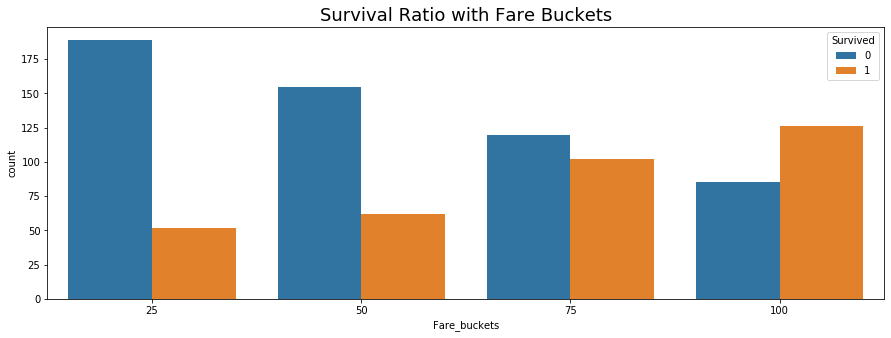

In [86]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(train_dt['Fare_buckets'],hue=train_dt['Survived'],ax=ax)
ax.set_title('Survival Ratio with Fare Buckets',fontsize=18)

<div class='alert alert-block alert-info'>
    <p>It seems like paying more can increase the chances of survival. Proper Coorelation will determine the impact of Fare on Survival</p>
</div>

9. Boxplot analysis of Fare. 

In [87]:
train_dt['Survived_trans'] = train_dt['Survived'].apply(lambda x: 'Survived' if x==1 else 'Died')

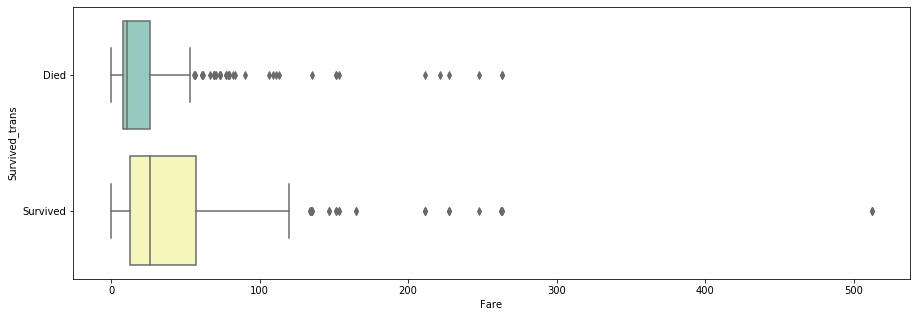

In [88]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x=train_dt['Fare'],y=train_dt['Survived_trans'],ax=ax,palette="Set3")

10. Point Biserial Correlation

In [89]:
pointbiserialr(train_dt['Fare'],train_dt['Survived'])

PointbiserialrResult(correlation=0.2573065223849624, pvalue=6.120189341917992e-15)

11. Logistic Regression

In [90]:
X = train_dt['Fare'].values
y = train_dt['Survived']

In [91]:
X = X.reshape(-1,1)

In [92]:
X_train,X_test, Y_train, Y_test = train_test_split(X,y)

In [93]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [94]:
Y_pred = clf.predict(X_test)

In [95]:
cross_val_score(clf,X_train, Y_train, cv=20)

array([0.64705882, 0.73529412, 0.73529412, 0.85294118, 0.52941176,
       0.73529412, 0.67647059, 0.67647059, 0.66666667, 0.60606061,
       0.72727273, 0.66666667, 0.66666667, 0.72727273, 0.57575758,
       0.72727273, 0.51515152, 0.60606061, 0.6969697 , 0.60606061])

In [96]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.65      0.92      0.77       140
           1       0.58      0.18      0.28        83

    accuracy                           0.65       223
   macro avg       0.62      0.55      0.52       223
weighted avg       0.63      0.65      0.58       223



In [97]:
accuracy_score(Y_test,Y_pred)

0.6457399103139013

In [98]:
confusion_matrix(Y_test,Y_pred)

array([[129,  11],
       [ 68,  15]])

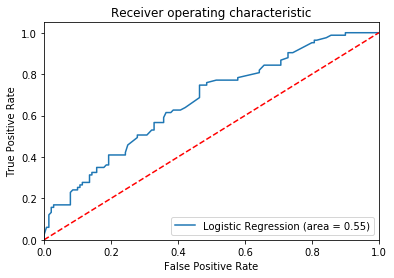

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

12. Chisquare test for Age_range with Survival.

In [100]:
Fare_buc_CrossTab = pd.crosstab(train_dt['Fare_buckets'],train_dt['Survived'])

In [101]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(Fare_buc_CrossTab)

In [102]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 83.58353043596506 P-Value 5.2260449431066106e-18


In [103]:
cramers_corrected_stat(train_dt,testStatistic,Fare_buc_CrossTab)

0.30645423427503177

13. Colinearity between PClass and Fare:

i. What is the average fare per passenger class?

In [104]:
train_dt.groupby(by=['Pclass'])['Fare'].mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

ii. What is the coorelation between PClass and Fare?

In [105]:
median_fare = np.median(train_dt['Fare'])
median_fare

14.4542

In [106]:
pointbiserialr(train_dt['Fare'],train_dt['Pclass'])

PointbiserialrResult(correlation=-0.5494996199439078, pvalue=1.967386173420501e-71)

ii. Box plot of Fare in different Pclass

In [107]:
train_dt['Pclass_trans'] = train_dt['Pclass'].apply(lambda x: 'Elite Class' if x==1 else
                                                    ('Middle class' if x==2 else 'Lower Class'))

Text(0.5, 1.0, 'Fare Distribution in different Passenger Class')

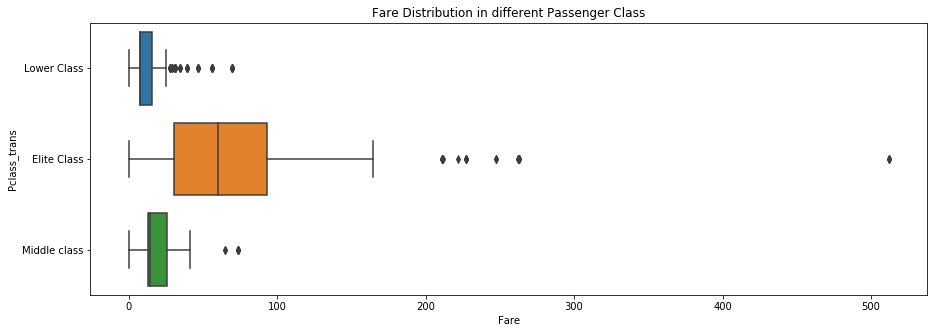

In [108]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='Pclass_trans',x='Fare',data=train_dt)
ax.set_title('Fare Distribution in different Passenger Class')

iv. Chi square Fare bucket and Pclass

In [109]:
Fare_buc_CrossTab = pd.crosstab(train_dt['Fare_buckets'],train_dt['Pclass'])

In [110]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(Fare_buc_CrossTab)

In [111]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 566.7189020378853 P-Value 3.509657501057859e-119


In [112]:
cramers_corrected_stat(train_dt,testStatistic,Fare_buc_CrossTab)

0.5645709394375059

v. logistic regression with Fare and Pclass

In [113]:
train_dt['Fare'] = train_dt['Fare'].apply(lambda x: np.median(train_dt['Fare']) if x==0 else x)

In [114]:
X = train_dt['Fare'].values
y = train_dt['Pclass']

In [115]:
X = X.reshape(-1,1)

In [116]:
X_train,X_test, Y_train, Y_test = train_test_split(X,y)

In [117]:
clf = LogisticRegression(solver='lbfgs',multi_class='auto').fit(X_train, Y_train)
scores = cross_val_score(clf, X_train, Y_train, cv=10)
print(scores)

[0.71641791 0.70149254 0.71641791 0.68656716 0.73134328 0.67164179
 0.70149254 0.67164179 0.65151515 0.6969697 ]


In [118]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ValueError: multi_class must be in ('ovo', 'ovr')

### Embarked: 

1. What is the distribution? 

In [119]:
round(train_dt.groupby(by=['Embarked'])['PassengerId'].count()/len(train_dt)*100)

Embarked
C    19.0
Q     9.0
S    72.0
Name: PassengerId, dtype: float64

2. What is survival percentage of each embarked location ? 

In [120]:
train_dt[train_dt['Survived']==1].groupby(by=['Embarked'])['PassengerId'].count()/len(train_dt)*100

Embarked
C    10.437710
Q     3.367003
S    24.354658
Name: PassengerId, dtype: float64

3. Barplot of Embarked and Survival

In [121]:
grp_dt = train_dt[['Embarked','Survived','PassengerId']].groupby(by=['Embarked','Survived']).count().reset_index()
grp_dt

Embarked  Survived  PassengerId
0        C         0           75
1        C         1           93
2        Q         0           47
3        Q         1           30
4        S         0          427
5        S         1          217

Text(0, 0.5, 'Frequency')

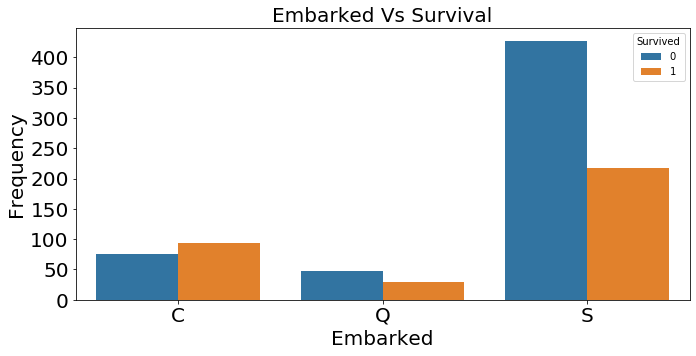

In [122]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Embarked',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Embarked Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Embarked', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p>Need to update</p>
</div>

4. Coorelation of Embarked With Survival. 

In [123]:
EmbrkCrossTab = pd.crosstab(train_dt['Embarked'],train_dt['Survived'])

In [124]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(EmbrkCrossTab)

In [125]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 26.48914983923762 P-Value 1.769922284120912e-06


In [126]:
cramers_corrected_stat(train_dt,testStatistic,EmbrkCrossTab)

0.1725199329989738

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Sex is one of the decisive feature in this problem and the coorelation is reasonable (not too weak not too strong) </p>
</div>

5. How many records in which embark is missing? 

In [127]:
train_dt['Embarked'].notnull().value_counts()

True     889
False      2
Name: Embarked, dtype: int64

6. Replace missing with mode

In [128]:
replacement = train_dt['Embarked'].mode()

In [129]:
train_dt['Embarked'] = train_dt['Embarked'].fillna(value=replacement)

7. What is the association after filling out NA ?

In [130]:
EmbrkCrossTab = pd.crosstab(train_dt['Embarked'],train_dt['Survived'])

In [131]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(EmbrkCrossTab)

In [132]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 26.48914983923762 P-Value 1.769922284120912e-06


In [133]:
cramers_corrected_stat(train_dt,testStatistic,EmbrkCrossTab)

0.1725199329989738

## Test 

## Machine Learning

In [134]:
X = pd.get_dummies(temp[['Sex','Pclass','SibSp','Parch','Embarked','Fare']])
X

Pclass  SibSp  Parch     Fare  Sex_female  Sex_male  Embarked_C  \
0         3      1      0   7.2500           0         1           0   
1         1      1      0  71.2833           1         0           1   
2         3      0      0   7.9250           1         0           0   
3         1      1      0  53.1000           1         0           0   
4         3      0      0   8.0500           0         1           0   
..      ...    ...    ...      ...         ...       ...         ...   
885       3      0      5  29.1250           1         0           0   
886       2      0      0  13.0000           0         1           0   
887       1      0      0  30.0000           1         0           0   
889       1      0      0  30.0000           0         1           1   
890       3      0      0   7.7500           0         1           0   

     Embarked_Q  Embarked_S  
0             0           1  
1             0           0  
2             0           1  
3             0           1  
4             0           1  
..          ...         ...  
885           1           0  
886           0           1  
887           0           1  
889           0           0  
890           1           0  

[714 rows x 9 columns]

In [135]:
X = X[['Pclass', 'Sex_female','Sex_male','Embarked_C','Embarked_Q', 'Embarked_S']]
y = temp['Survived']

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y)

In [137]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, Y_train, cv=20)
scores

array([0.66666667, 0.77777778, 0.81481481, 0.74074074, 0.7037037 ,
       0.74074074, 0.77777778, 0.92592593, 0.77777778, 0.77777778,
       0.77777778, 0.66666667, 0.62962963, 0.85185185, 0.77777778,
       0.80769231, 0.84615385, 0.92307692, 0.69230769, 0.84615385])

In [138]:
np.average(scores)*100

77.61396011396012

In [139]:
test  = train_dt['Survived'].tolist()

In [140]:
decision_tree = DecisionTreeClassifier(splitter="best"#, min_samples_leaf=50,
                                    #min_samples_split=15,
                                    #   max_depth=4,
                                   #  ,min_impurity_decrease=0.009,
                                      ).fit(X_train,Y_train)

In [141]:
Y_pred = decision_tree.predict(X_test)

In [142]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84        97
           1       0.91      0.65      0.76        82

    accuracy                           0.81       179
   macro avg       0.84      0.80      0.80       179
weighted avg       0.83      0.81      0.80       179



In [143]:
accuracy_score(Y_test,Y_pred)

0.8100558659217877

In [144]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred,labels=[0,1]).ravel()


In [145]:
confusion_matrix(Y_pred,Y_test,labels=[0,1])

array([[92, 29],
       [ 5, 53]])

In [146]:
pd.DataFrame({'features': X_train.columns,'imp':decision_tree.feature_importances_})

features       imp
0      Pclass  0.268412
1  Sex_female  0.000000
2    Sex_male  0.687693
3  Embarked_C  0.034427
4  Embarked_Q  0.003784
5  Embarked_S  0.005683

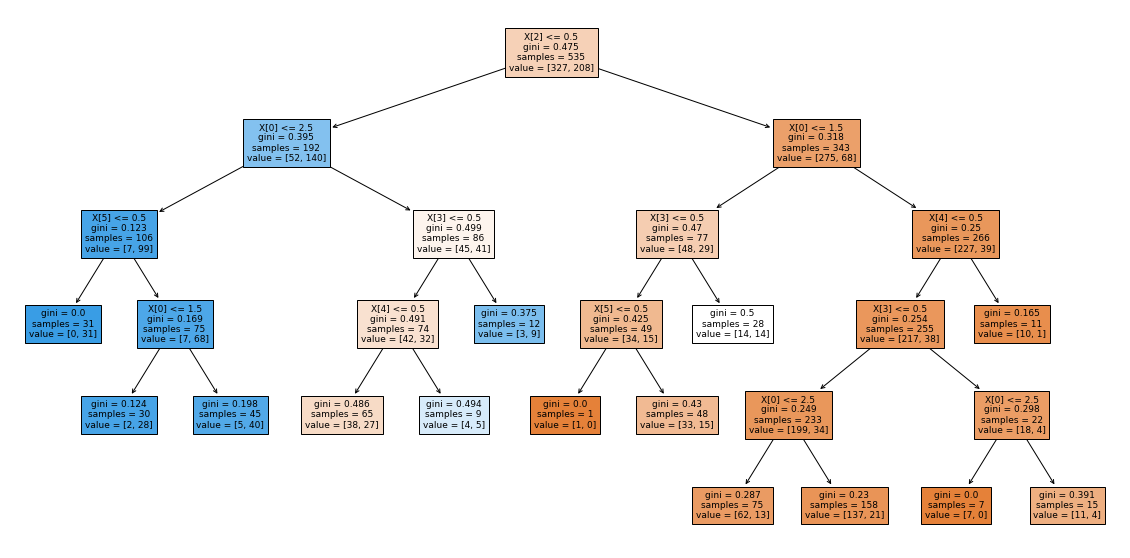

In [147]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree,fontsize=9,filled=True)
plt.show()

In [148]:
from sklearn.tree import export_graphviz

# Creates dot file named tree.dot
export_graphviz(
            decision_tree,
            out_file =  "myTreeName2.dot",
            feature_names = list(X.columns),
            class_names = y.astype(str),
            filled = True,
            rounded = True)

# Feature Engineering: 

## 1. Family Size:

In [155]:
train_dt['Family_size'] = train_dt['SibSp'] + train_dt['Parch'] + 1

1. What is the association of family size with outcome?

In [156]:
FamilyCrossTab = pd.crosstab(train_dt['Family_size'],train_dt['Survived'])

In [157]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(FamilyCrossTab)

In [158]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 80.67231343783078 P-Value 3.579668975443533e-14


In [159]:
cramers_corrected_stat(train_dt,testStatistic,FamilyCrossTab)

0.30107003045893016

## 2. Title: 

In [ ]:
train_dt['Name']

## 3. Is_Alone:

In [233]:
train_dt['Is_alone'] = train_dt['Family_size'].apply(lambda x: 1 if x==1 else 0 )

In [234]:
train_dt[['Survived','Is_alone']].groupby(by=['Is_alone']).count()

Survived
Is_alone          
0              354
1              537

1. What is the association of is alone with outcome?

In [235]:
IsAloneCrossTab = pd.crosstab(train_dt['Is_alone'],train_dt['Survived'])

In [236]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(IsAloneCrossTab)

In [237]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 36.00051446773865 P-Value 1.9726543846517113e-09


In [238]:
cramers_corrected_stat(train_dt,testStatistic,IsAloneCrossTab)

0.20112202097919463

## 4. Fare Band:

In [266]:
train_dt['FareBand'] = pd.cut(train_dt['Fare'], 5,labels=[1,2,3,4,5])
train_dt['FareBand'].value_counts()


1    838
2     33
3     17
5      3
4      0
Name: FareBand, dtype: int64

## Machine Learning # 02

In [335]:
X = pd.get_dummies(train_dt[['Age','Sex','Pclass','Fare','Embarked','Is_alone']])
X

Age  Pclass     Fare  Is_alone  Sex_female  Sex_male  Embarked_C  \
0    22.000000       3   7.2500         0           0         1           0   
1    38.000000       1  71.2833         0           1         0           1   
2    26.000000       3   7.9250         1           1         0           0   
3    35.000000       1  53.1000         0           1         0           0   
4    35.000000       3   8.0500         1           0         1           0   
..         ...     ...      ...       ...         ...       ...         ...   
886  27.000000       2  13.0000         1           0         1           0   
887  19.000000       1  30.0000         1           1         0           0   
888  29.699118       3  23.4500         0           1         0           0   
889  26.000000       1  30.0000         1           0         1           1   
890  32.000000       3   7.7500         1           0         1           0   

     Embarked_Q  Embarked_S  
0             0           1  
1             0           0  
2             0           1  
3             0           1  
4             0           1  
..          ...         ...  
886           0           1  
887           0           1  
888           0           1  
889           0           0  
890           1           0  

[891 rows x 9 columns]

In [336]:
#X = X[['Pclass', 'Sex_female','Sex_male','Embarked_C','Embarked_Q', 'Embarked_S','Family_size']]
y = train_dt['Survived']

In [337]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y)

In [338]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, Y_train, cv=20)
scores

array([0.88235294, 0.67647059, 0.70588235, 0.73529412, 0.79411765,
       0.70588235, 0.76470588, 0.76470588, 0.81818182, 0.78787879,
       0.75757576, 0.84848485, 0.84848485, 0.6969697 , 0.87878788,
       0.72727273, 0.84848485, 0.78787879, 0.72727273, 0.72727273])

In [339]:
np.average(scores)*100

77.41978609625669

In [340]:
decision_tree = DecisionTreeClassifier(splitter="best",# min_samples_leaf=50,
                                  #  min_samples_split=200,
                                  #    max_depth=4,
                                 #  min_impurity_decrease=0.001,
                                  #    class_weight={0:1, 1:1.4},
                                  #     min_weight_fraction_leaf=0.39
                                      ).fit(X_train,Y_train)

In [341]:
Y_pred = decision_tree.predict(X_test)

In [342]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       144
           1       0.66      0.73      0.69        79

    accuracy                           0.77       223
   macro avg       0.75      0.76      0.76       223
weighted avg       0.78      0.77      0.77       223



In [343]:
accuracy_score(Y_test,Y_pred)

0.7713004484304933

In [344]:
precision_score(Y_test,Y_pred, labels=[0,1])

0.6590909090909091

In [345]:
recall_score(Y_test,Y_pred, labels=[0,1])

0.7341772151898734

In [346]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred,labels=[0,1]).ravel()


In [347]:
confusion_matrix(Y_pred,Y_test,labels=[0,1])

array([[114,  21],
       [ 30,  58]])

In [348]:
np.unique(Y_pred, return_counts=True)

(array([0, 1]), array([135,  88]))

In [349]:
np.unique(Y_test, return_counts=True)

(array([0, 1]), array([144,  79]))

In [350]:
pd.DataFrame({'features': X_train.columns,'imp':decision_tree.feature_importances_}).sort_values(by=['imp'],ascending=False)

features       imp
5    Sex_male  0.337692
0         Age  0.269319
2        Fare  0.248352
1      Pclass  0.104897
8  Embarked_S  0.016059
6  Embarked_C  0.013323
3    Is_alone  0.006042
7  Embarked_Q  0.004316
4  Sex_female  0.000000

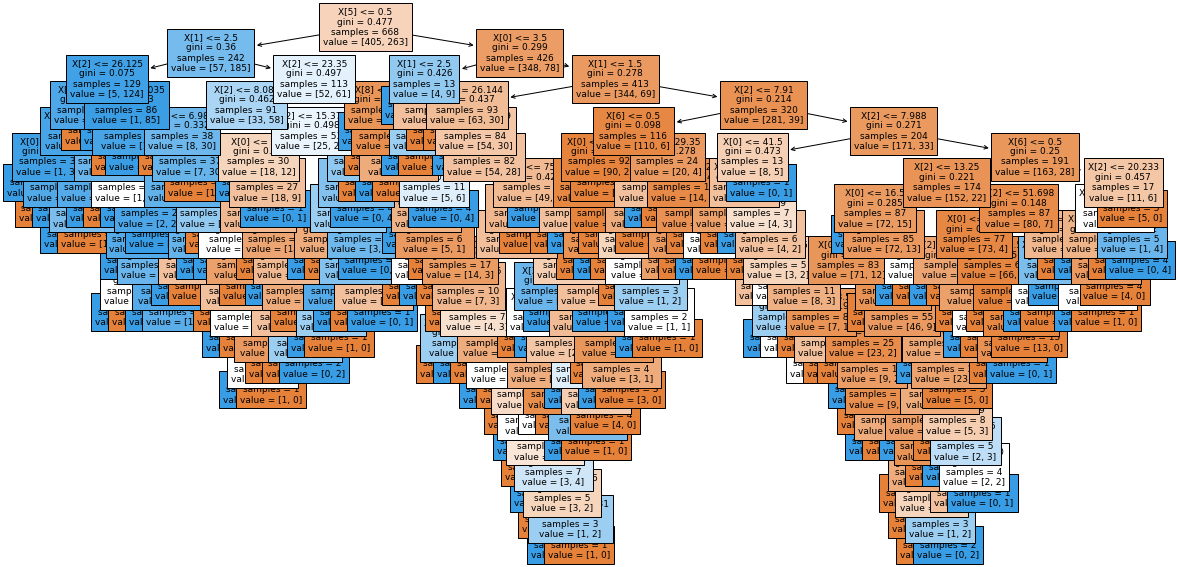

In [351]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree,fontsize=9,filled=True)
plt.show()

-------------------------

Kaggle submission 

-------------------

In [307]:
test_dt['Family_size'] = test_dt['SibSp'] + train_dt['Parch']

In [326]:
test_dt['Fare'] = test_dt['Fare'].fillna(14)

In [311]:
test_dt['Is_alone'] = test_dt['Family_size'].apply(lambda x: 1 if x==1 else 0 )

In [327]:
X = pd.get_dummies(test_dt[['Sex','Pclass','Fare','Embarked','Is_alone']])

In [328]:
#X = X[['Pclass', 'Sex_female','Sex_male','Embarked_C','Embarked_Q', 'Embarked_S','Family_size']]

In [329]:
predicted = decision_tree.predict(X)

In [330]:
output = pd.DataFrame({'PassengerId': test_dt.PassengerId, 'Survived': predicted})

In [331]:
output.to_csv('submission.csv',index=False)

In [332]:
output['Survived'].value_counts()

0    289
1    129
Name: Survived, dtype: int64

In [325]:
test_dt.columns[test_dt.isnull().any()]

Index(['Age', 'Fare', 'Cabin'], dtype='object')

In [ ]:
decision_tree

In [334]:
train_dt['Age'] = train_dt['Age'].fillna(np.mean(train_dt['Age']))